In [ ]:
import albumentations as A
import cv2
import numpy as np
from google.colab import drive
image_size = 512
import imgaug
imgaug.random.seed(123)
import random
random.seed(7)

Create transforms to augment data

In [ ]:
mult = -(image_size//-9)
transform = A.Compose([
    A.RandomScale(scale_limit=.1),
    A.Resize(9*mult,16*mult),
    #A.RandomRotate90(),
    A.RandomCrop(width=image_size, height=image_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=.5,brightness_limit=.3,contrast_limit=.3),
    #A.ColorJitter(p=.5),
])
testtransform = A.Compose([
    #A.RandomScale(scale_limit=(2,3)),
    A.Resize(9*mult,16*mult),
    #A.RandomRotate90(),
    A.CenterCrop(width=image_size, height=image_size),
    A.HorizontalFlip(p=0.5),
])

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


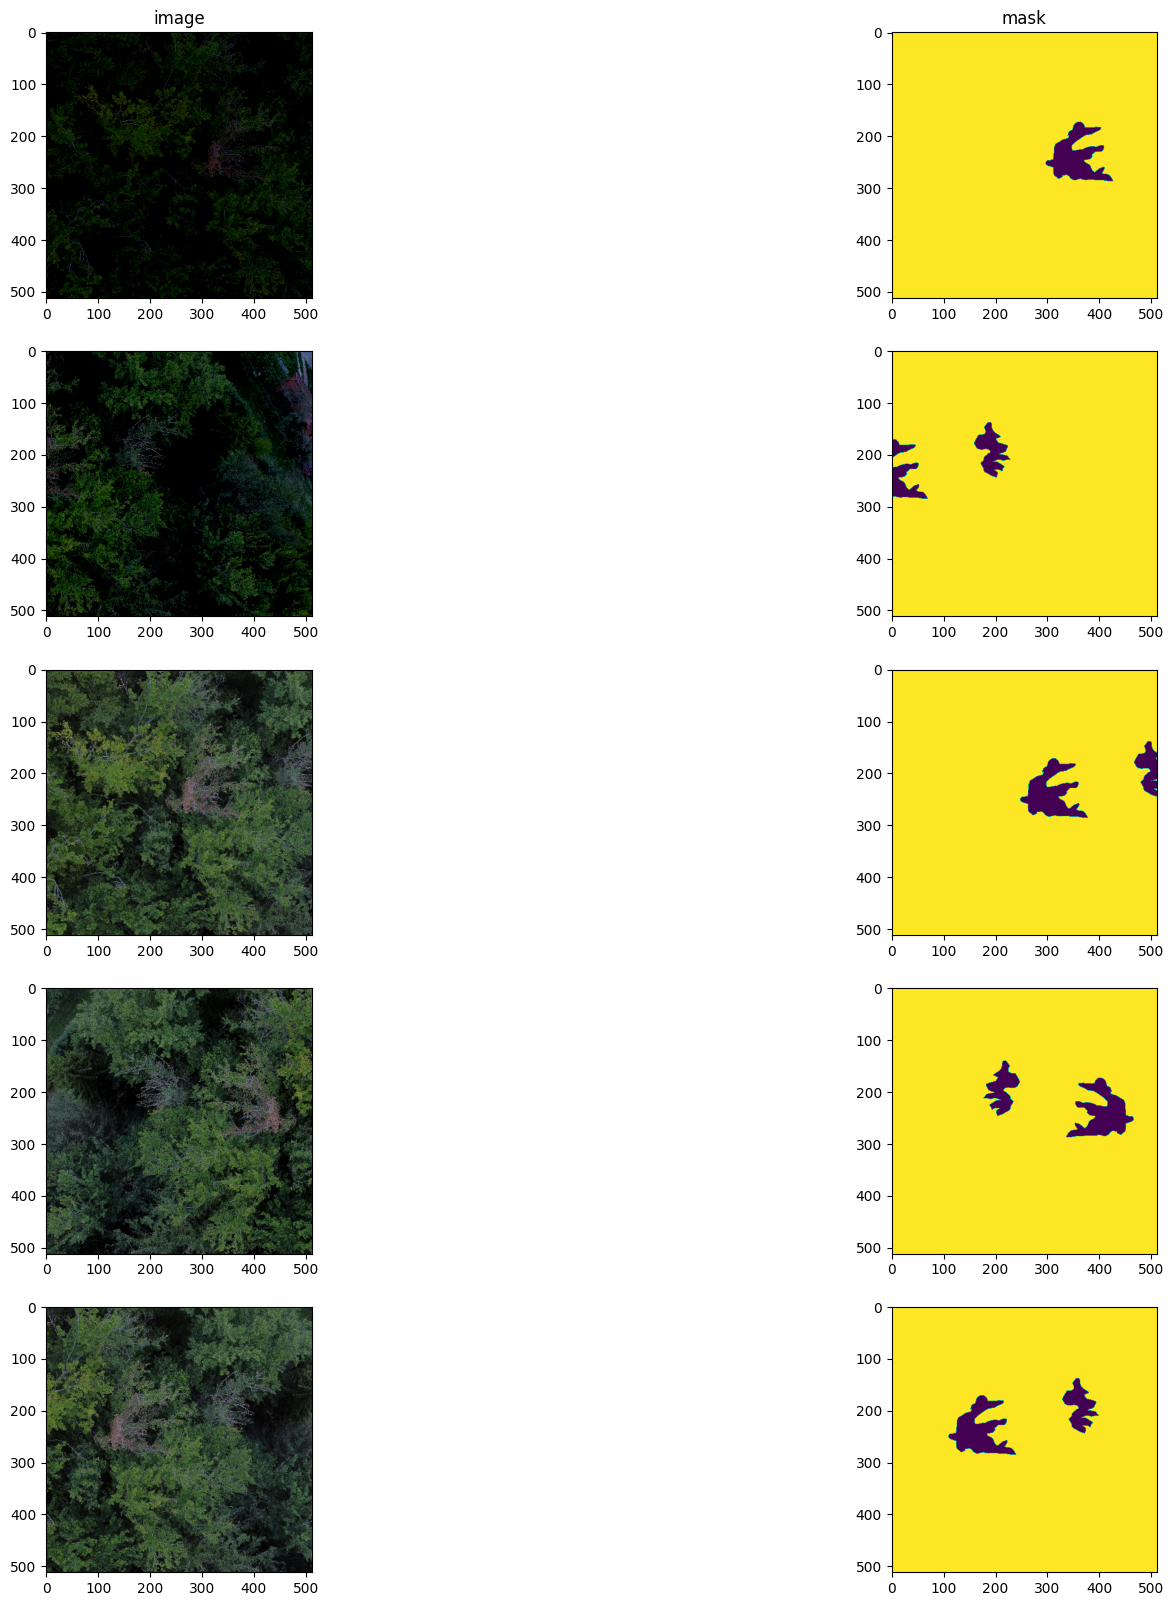

In [ ]:
from matplotlib import pyplot as plt

image = cv2.imread('drive/MyDrive/tree_segmentation/original/sick/image/DJI_0033.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread('drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0033.png', cv2.IMREAD_GRAYSCALE)

N = 5
f, ax = plt.subplots(N, 2, figsize=(20, 20))
ax[0][0].set_title("image")
ax[0][1].set_title("mask")
for i in range(N):
  HealthyMask = True
  while HealthyMask:
    transformed = transform(image=image,mask=mask)
    #run until at least 10% of pixels are of sick trees so we get an interesting image
    HealthyMask = np.sum(transformed['mask']!=255)>.1*image_size**2
  ax[i][0].imshow(transformed['image'])
  ax[i][1].imshow(transformed['mask'])


In [ ]:
import glob
sick_images = glob.glob('drive/MyDrive/tree_segmentation/original/sick/image/*.JPG')
sick_masks = glob.glob('drive/MyDrive/tree_segmentation/original/sick/mask/*.png')
healthy_images = glob.glob('drive/MyDrive/tree_segmentation/original/healthy/image/*.JPG')
healthy_masks = glob.glob('drive/MyDrive/tree_segmentation/original/healthy/mask/*.png')

sick_images.sort()
sick_masks.sort()
healthy_images.sort()
healthy_masks.sort()

sick = []
healthy = []
for i,m in zip(sick_images,sick_masks):
  sick.append({'image':i,'mask':m})

for i in healthy_images:
  healthy.append({'image':i,'mask':healthy_masks[0]})

print(sick)
print(healthy)

[{'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0031.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0031.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0032.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0032.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0033.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0033.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0034.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0034.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0035.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0035.png'}, {'image': 'drive/MyDrive/tree_segmentation/original/sick/image/DJI_0036.JPG', 'mask': 'drive/MyDrive/tree_segmentation/original/sick/mask/MaskDJI_0036.png'}, {'image': 'drive/MyDrive/tree_segmentation/original

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
total_sick = len(sick_images)
#add in some healthy images
total_healthy = len(healthy_images)
healthy_to_use = round(total_sick*.2)
healthy_idx = np.random.choice(total_healthy,healthy_to_use)
filepaths = tf.data.Dataset.from_tensor_slices((sick_images+[healthy_images[i] for i in healthy_idx],sick_masks+healthy_masks*healthy_to_use))
#filepaths = tf.data.Dataset.from_tensor_slices((sick_images,sick_masks))

In [ ]:
def load_and_preprocess_image(image_path, mask_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.uint8)
    #image = tf.image.convert_image_dtype(image, tf.float32)

    # Load and preprocess the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, dtype=tf.uint8)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = 1-tf.math.round(mask)  # Ensure binary mask (0 or 1) #invert mask

    return image, mask

In [ ]:
dataset = filepaths.map(load_and_preprocess_image)

In [ ]:
total_samples = len(dataset)#+len(healthy_images)
print(total_samples)
train_size = round(0.8 * total_samples)
print(train_size)
validation_size = total_samples - train_size
print(validation_size)
dataset = dataset.shuffle(100,seed=10)

train_dataset,validation_dataset = tf.keras.utils.split_dataset(dataset,left_size=.8)

31
25
6


In [ ]:
def apply_augmentation(image,mask):
  transformed = transform(image=image,mask=mask)
  aug_img = transformed["image"]
  aug_img = tf.cast(aug_img/255, tf.float32)
  aug_img = tf.image.resize(aug_img, size=[image_size, image_size])
  aug_mask = transformed["mask"]
  aug_mask = tf.cast(aug_mask, tf.float32)
  aug_mask = tf.image.resize(aug_mask, size=[image_size, image_size])
  return aug_img, aug_mask

def process_data(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=apply_augmentation, inp=[image, mask], Tout=(tf.float32, tf.float32))
    aug_img.set_shape((image_size,image_size,3))
    aug_mask.set_shape((image_size,image_size,1))
    return aug_img, aug_mask

def apply_augmentation_test(image,mask):
  transformed = testtransform(image=image,mask=mask)
  aug_img = transformed["image"]
  aug_img = tf.cast(aug_img/255, tf.float32)
  aug_img = tf.image.resize(aug_img, size=[image_size, image_size])
  aug_mask = transformed["mask"]
  aug_mask = tf.cast(aug_mask, tf.float32)
  aug_mask = tf.image.resize(aug_mask, size=[image_size, image_size])
  return aug_img, aug_mask

def process_data_test(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=apply_augmentation_test, inp=[image, mask], Tout=(tf.float32, tf.float32))
    aug_img.set_shape((image_size,image_size,3))
    aug_mask.set_shape((image_size,image_size,1))
    return aug_img, aug_mask


In [ ]:
augmented_dataset = dataset.map(process_data).batch(32).prefetch(AUTOTUNE)

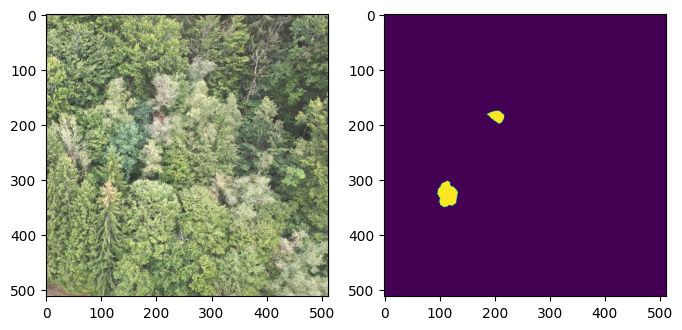

In [ ]:
def view_image(ds):
    image, mask = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    mask = mask.numpy()
    f, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(image[0])
    ax[1].imshow(mask[0])

view_image(augmented_dataset)

In [ ]:
TRAIN_LENGTH = train_size
BATCH_SIZE = 1
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_batches = (
    train_dataset
    .map(process_data)
    .cache()
    .shuffle(BUFFER_SIZE,seed=10)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

#test_batches = validation_dataset.map(process_data_test).batch(BATCH_SIZE).repeat()
test_batches = (
    validation_dataset
    .map(process_data_test)
    .cache()
    .shuffle(BUFFER_SIZE,seed=10)
    .batch(BATCH_SIZE))
    #.repeat())

final_batches = validation_dataset.map(process_data_test).batch(BATCH_SIZE)
type(train_batches)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  titles = ['Original Image', 'Original Mask', 'Generated Mask', 'Heat Map']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

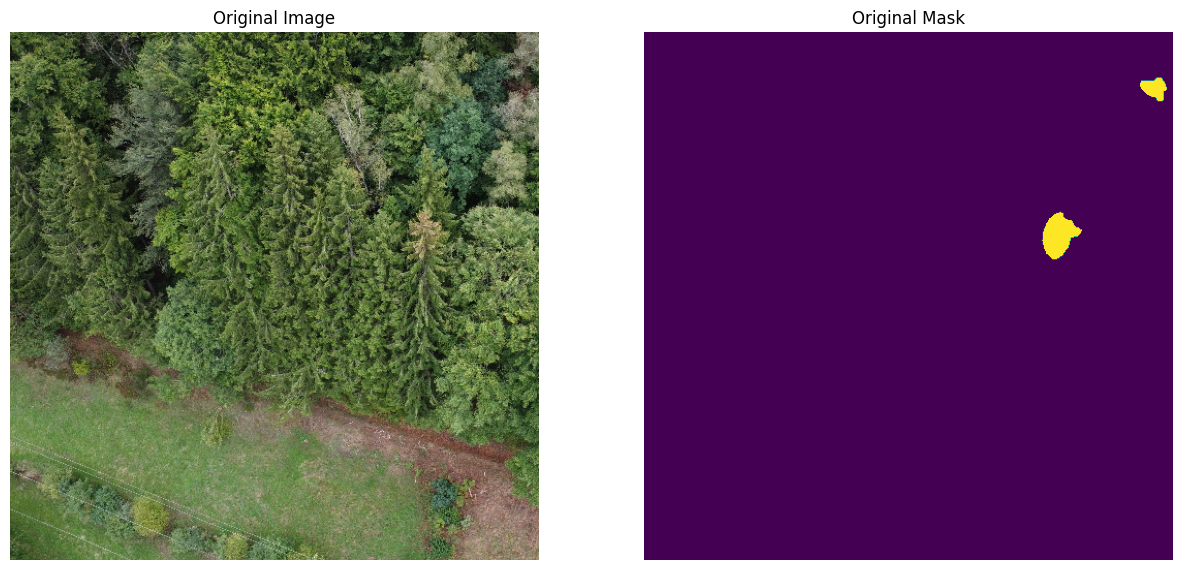

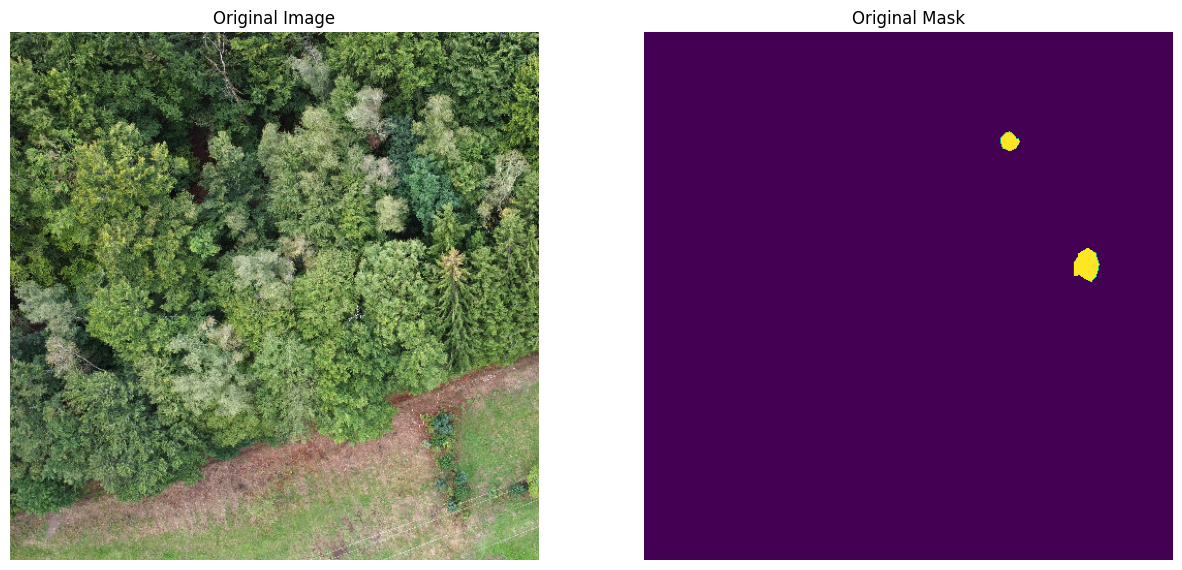

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
!pip install git+https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git

  Cloning https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git to /tmp/pip-req-build-dy9mkotq
  Running command git clone --filter=blob:none --quiet https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git /tmp/pip-req-build-dy9mkotq
  Resolved https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git to commit 3714839ee49759b26e2b0ae3d3a0aa37b00df962
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-advanced-segmentation-models: filename=tensorflow_advanced_segmentation_models-0.4.10-py3-none-any.whl size=37942 sha256=fee357407a9ba0fff542ea5620070e7b0415920ae2eda046b02c28ada0ed51a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-jy6vzz4p/wheels/81/31/ae/80a6d6e86cebbc1f084947259d621128bf26c78448511b1461
Successfully built tensorflow-advanced-segmentation-models


In [ ]:
import tensorflow_advanced_segmentation_models as tasm

94668760/94668760 [==============================] - 6s 0us/step


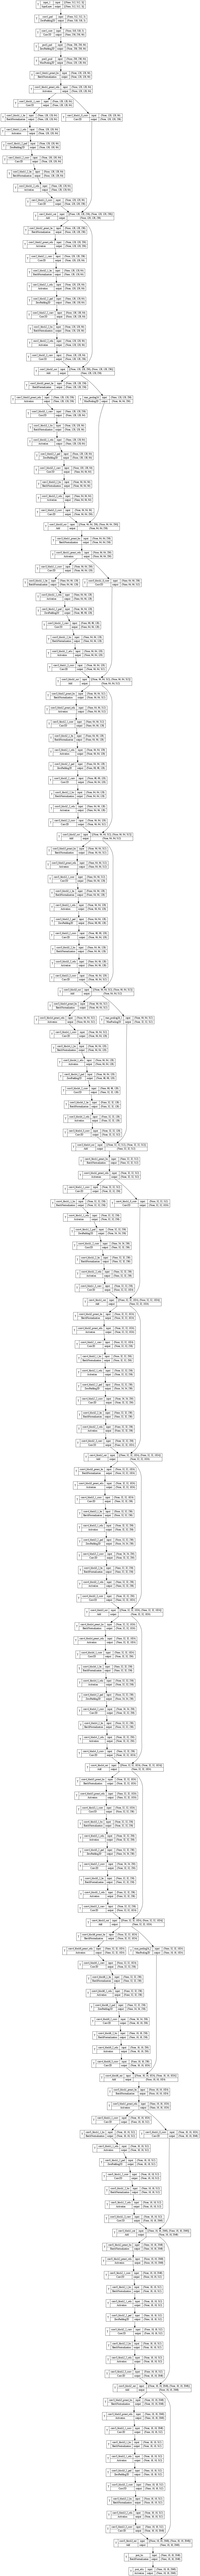

In [ ]:
BACKBONE_NAME = "resnet50v2"
WEIGHTS = "imagenet"

base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=image_size, width=image_size)

tf.keras.utils.plot_model(base_model,show_shapes=True,dpi=60,show_layer_names=True,show_trainable=True)

In [ ]:
model = tasm.UNet(n_classes=2, base_model=base_model, output_layers=layers, backbone_trainable=False).model()

In [ ]:
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()
model.compile(optimizer='adam',
              #optimizer=tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss = categorical_focal_dice_loss,
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

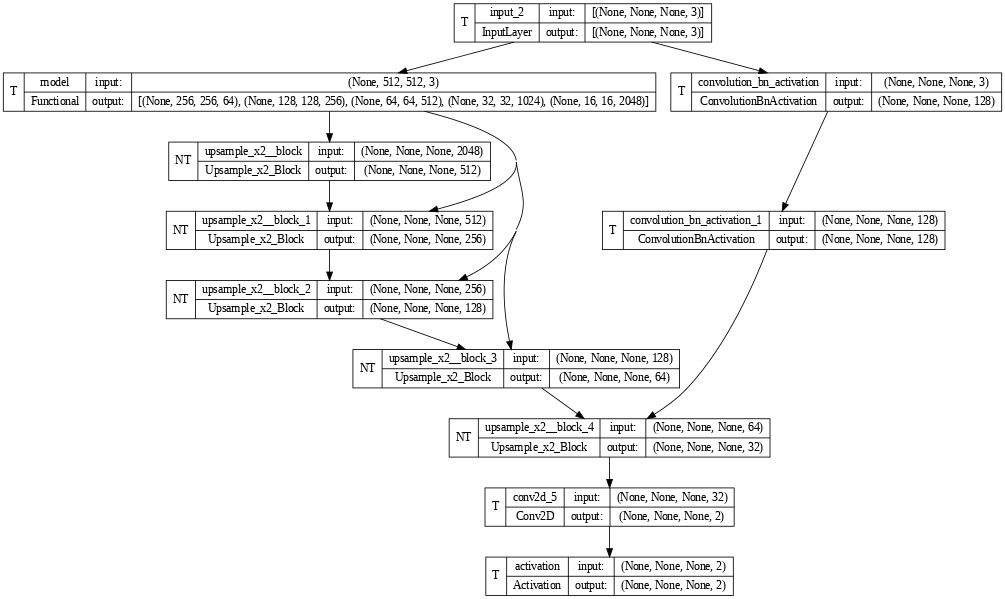

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,dpi=60,show_layer_names=True,show_trainable=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      #display([image[0], mask[0], create_mask(pred_mask)])
      for i in range(BATCH_SIZE):
        try:
          display([image[i], mask[i], create_mask(pred_mask[i]), (pred_mask[:,:,:,1, tf.newaxis])[i]])
        except:
          pass
  else:
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image, sample_mask,create_mask(pred_mask[0]), (pred_mask[:,:,:,1, tf.newaxis])[0]])

In [ ]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


1/1 [==============================] - 0s 51ms/step


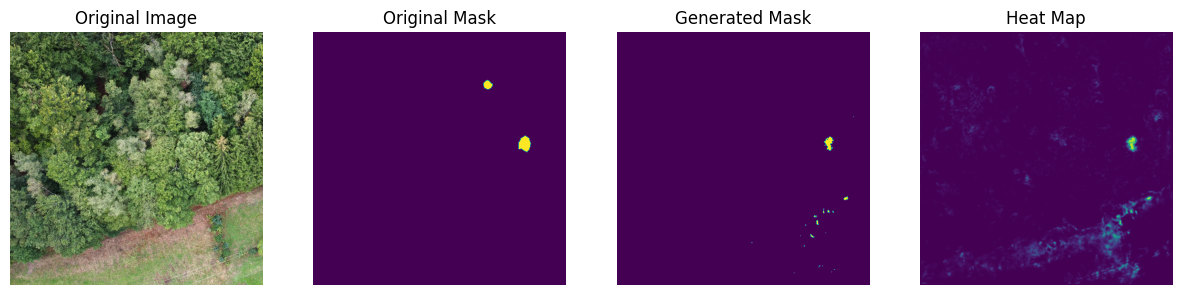


Sample Prediction after epoch 40


Epoch 40: val_loss did not improve from 0.08408
25/25 [==============================] - 6s 255ms/step - loss: 0.0624 - accuracy: 0.9815 - val_loss: 0.0960 - val_accuracy: 0.9701


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
EPOCHS = 40
VALIDATION_STEPS = len(validation_dataset)

filepath = 'segmentation_model2'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)


#reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max")

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=len(train_dataset),
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(),checkpoint])

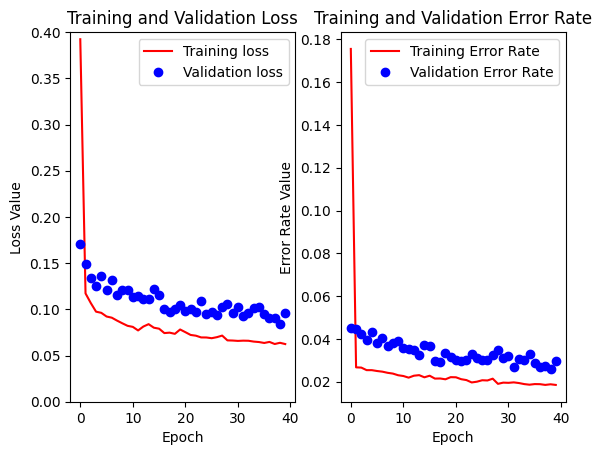

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure()
plt.subplot(121)
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, .4])
plt.legend()

error = 1-np.array(model_history.history['accuracy'])
val_error = 1-np.array(model_history.history['val_accuracy'])
plt.subplot(122)
#plt.figure()
plt.plot(model_history.epoch, error, 'r', label='Training Error Rate')
plt.plot(model_history.epoch, val_error, 'bo', label='Validation Error Rate')
plt.title('Training and Validation Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate Value')
#plt.ylim([8,. 1])
plt.legend()
plt.show()

1/1 [==============================] - 3s 3s/step


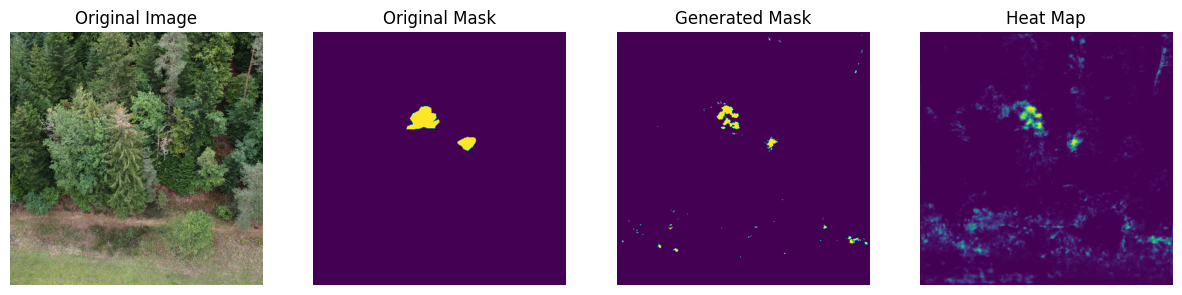

1/1 [==============================] - 0s 48ms/step


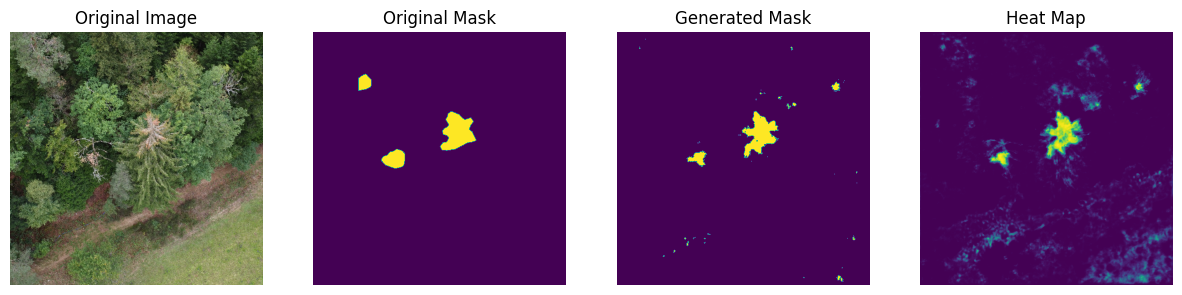

1/1 [==============================] - 0s 36ms/step


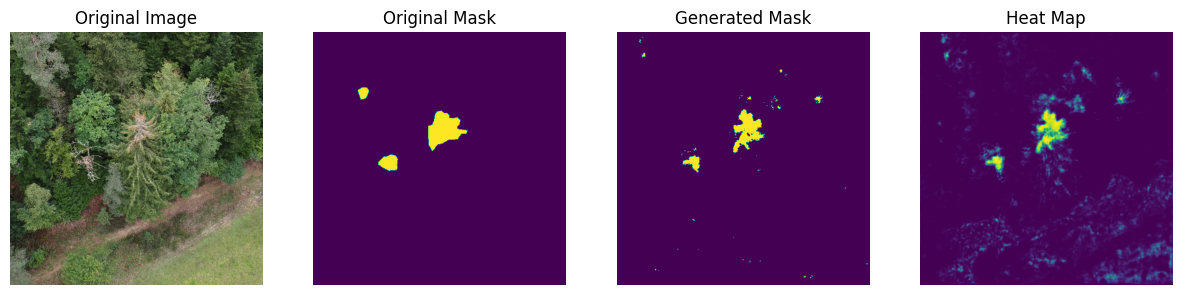

1/1 [==============================] - 0s 36ms/step


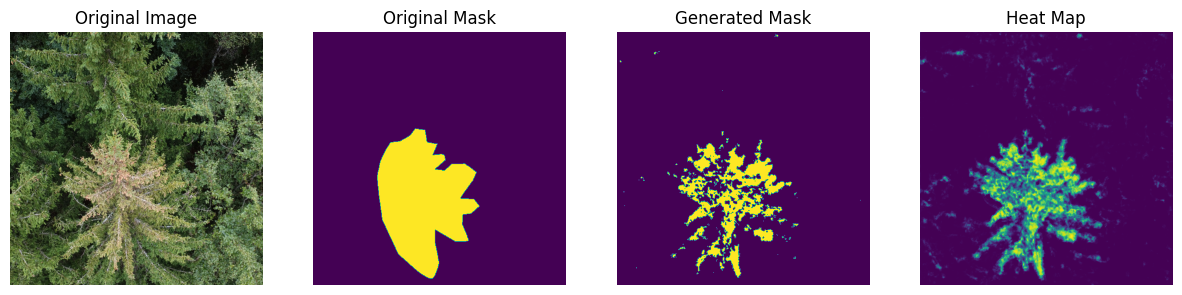

1/1 [==============================] - 0s 38ms/step


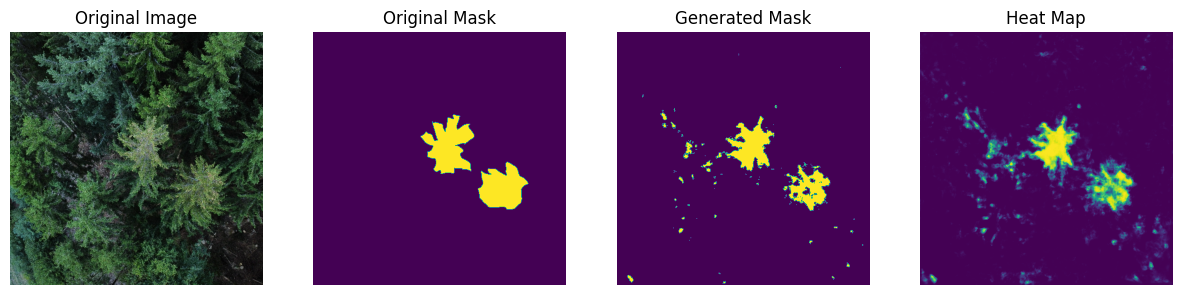

1/1 [==============================] - 0s 43ms/step


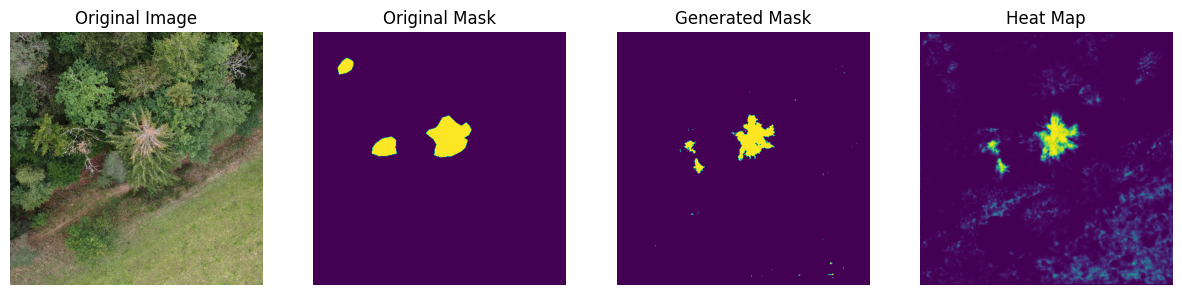

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(filepath)
show_predictions(final_batches, 20)


In [ ]:
from os import minor
random_seed = 20
dataset = filepaths.map(load_and_preprocess_image)
dataset = dataset.shuffle(100,seed=10)
nfolds = 10
EPOCHS = 30
#EPOCHS = 20
#VALIDATION_STEPS = 10
datafolds =[]
#create the folds
for i in range(nfolds):
  datafolds.append(dataset.shard(nfolds,i))

val_loss = []
score  = []
#take one fold as the test validation set and the rest as the test set
for i in range(nfolds):
  test = datafolds[i]
  trainlist = [datafolds[n] for n in range(nfolds) if n!=i]
  train = trainlist[0]
  for t in trainlist[1:]:
    train.concatenate(t)
  VALIDATION_STEPS=len(test)
  train_batches = (
      train
      .map(process_data)
      .cache()
      .shuffle(BUFFER_SIZE,seed=10)
      .batch(BATCH_SIZE)
      .repeat()
      .prefetch(buffer_size=tf.data.AUTOTUNE))

  test_batches = (
      test
      .map(process_data_test)
      .cache()
      .shuffle(BUFFER_SIZE,seed=10)
      .batch(BATCH_SIZE))
      #.repeat()
      #.prefetch(buffer_size=tf.data.AUTOTUNE))

  #now run the model and collect scores
  model = tasm.UNet(n_classes=2, base_model=base_model, output_layers=layers, backbone_trainable=False).model()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=len(train),
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)
  val_loss.append(model_history.history['val_loss'])
  score.append(min(model_history.history['val_loss']))
  print(model_history)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 31s 5s/step - loss: 0.7753 - accuracy: 0.5375 - val_loss: 0.5554 - val_accuracy: 0.7424
Epoch 2/30
3/3 [==============================] - 1s 402ms/step - loss: 0.4329 - accuracy: 0.8681 - val_loss: 0.3562 - val_accuracy: 0.9384
Epoch 3/30
3/3 [==============================] - 1s 496ms/step - loss: 0.2600 - accuracy: 0.9794 - val_loss: 0.2493 - val_accuracy: 0.9714
Epoch 4/30
3/3 [==============================] - 1s 419ms/step - loss: 0.1597 - accuracy: 0.9977 - val_loss: 0.1920 - val_accuracy: 0.9741
Epoch 5/30
3/3 [==============================] - 1s 414ms/step - loss: 0.1061 - accuracy: 0.9985 - val_loss: 0.1655 - val_accuracy: 0.9744
Epoch 6/30
3/3 [==============================] - 1s 500ms/step - loss: 0.0756 - accuracy: 0.9985 - val_loss: 0.1534 - val_accuracy: 0.9744
Epoch 7/30
3/3 [==============================] - 1s 495ms/step - loss: 0.0563 - accuracy: 0.9985 - val_loss: 0.1469 - val_accuracy: 0.9744
Epoch 8/30
3/3 [=================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

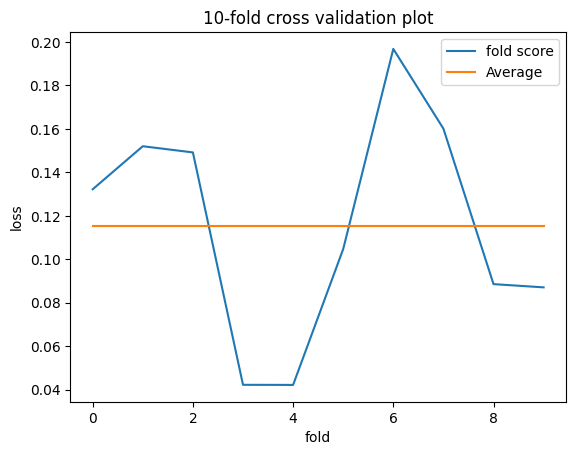

In [ ]:
plt.plot(score)
plt.title(f"{nfolds}-fold cross validation plot")
plt.xlabel("fold")
plt.ylabel("loss")
#plt.ylim([0,.2])
plt.plot([sum(score)/nfolds]*nfolds)
plt.legend(['fold score','Average'])

In [ ]:
print(sum(score)/nfolds)

0.11550478525459766


([<matplotlib.axis.XTick at 0x7e5d34295750>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

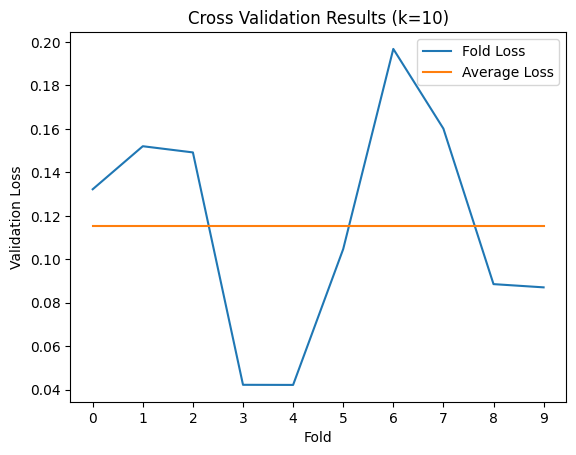

In [ ]:
x_ticks = range(nfolds)
plt.plot(score)
plt.title(f"Cross Validation Results (k={nfolds})")
plt.xlabel("Fold")
plt.ylabel("Validation Loss")
plt.plot([sum(score)/nfolds]*nfolds)
plt.legend(['Fold Loss','Average Loss'])
plt.xticks(ticks=x_ticks)

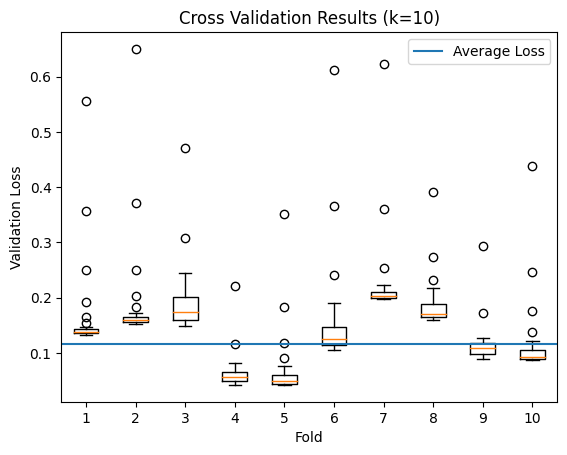

In [ ]:
avg = sum(score)/nfolds
fig, ax = plt.subplots()
plt.title(f"Cross Validation Results (k={nfolds})")
plt.xlabel("Fold")
plt.ylabel("Validation Loss")
plt.boxplot(val_loss)
ax.axline((1, avg), (nfolds, avg), label='Average Loss')
plt.legend()
plt.show()

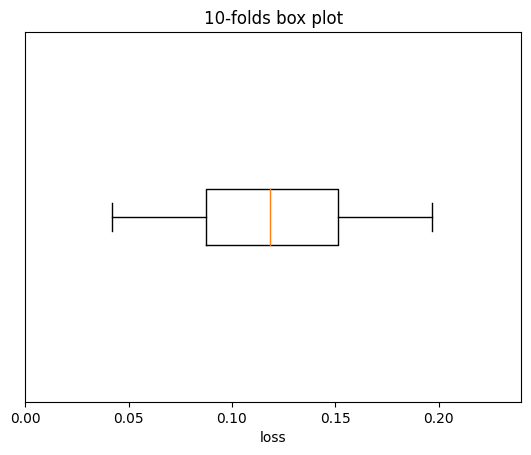

In [ ]:
plt.boxplot(score,vert=False)
plt.title("10-folds box plot")
plt.xlim(0, 0.24)
plt.xlabel("loss")
plt.yticks([])
plt.savefig('AlternativeModelBoxplot.png', dpi=300)

1/1 [==============================] - 5s 5s/step


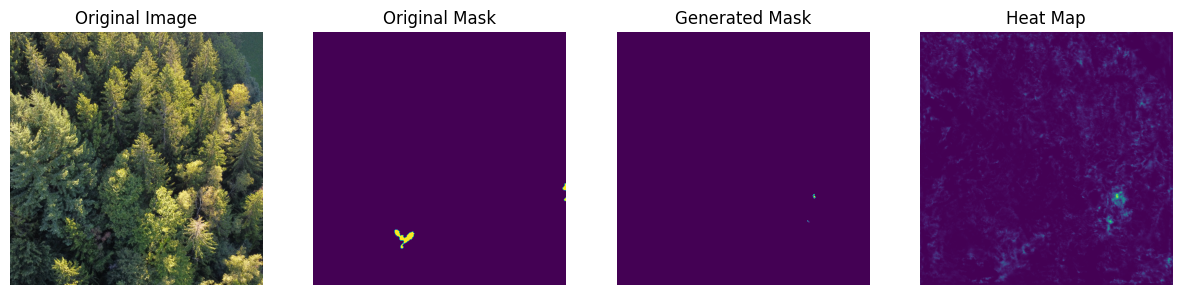

In [ ]:
show_predictions(train_batches)